# Native data from radars:

Radars from the Australian Bureau of Meteorology use the ODIM conventions (EU/Canada WMO standards) and the HDF file format to store radar data. This is supported by the Python library Py-ART and several other libraries.

In this notebook we will read a data file from the Bureau of Meteorology using Py-ART. We will plot the data  and transform it's coordinates to Cartesian (x, y, z). We will then apply this transformation to the data themselves, a process called gridding (interpolation + change of coordinates) to create data in native x, y, z coordinates.

We will use data from the Melbourne hailstorm from last month. Melbourne's Laverton radar is a dual-polarisation radar. While dual-polarisation radars are not the subject of this workshop, we think you should know a couple of things about them: 

### What dual-polarisation radars do?

- Theoretically, improve the accuracy of precipitation estimates, leading to better flash flood detection,
- Ability to discern between heavy rain, hail, snow, and sleet,
- Improved detection of non-meteorological echoes (e.g., ground clutter, chaff, anomalous propagation, birds, and tornado debris),
- Identification of the melting layer (e.g., bright band)

### What dual-polarisation radars don't do yet?

- Will not improve tornado lead times,
- Will not provide exact precipitation type at ground level,
- Will not make coffee.

### What is different from single-polarisation radars?

It can determine: 
- SIZE
- SHAPE
- VARIETY

In [1]:
%matplotlib inline

import pyart
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
radar_file = 'data/2_20200119_050000.pvol.h5'

In [3]:
radar = pyart.aux_io.read_odim_h5(radar_file, file_field_names=True)

In [4]:
radar.fields.keys()

dict_keys(['DBZH', 'DBZH_CLEAN', 'VRADDH', 'VRADH', 'WRADH', 'TH', 'ZDR', 'RHOHV', 'PHIDP', 'KDP', 'SNRH'])

- 'DBZH': Corrected reflectivity (first QC)
- 'DBZH_CLEAN': Corrected reflectivity (second QC)
- 'VRADDH': Dealiased Doppler velocity 
- 'VRADH': Doppler velocity
- 'WRADH': Spectrum width
- <p style="color:red">'TH': Total power - uncorrected raw reflectivity </p>
- 'ZDR': Differential reflecitivty
- 'RHOHV': Cross correlation ratio
- 'PHIDP': Differential phase
- 'KDP': Specific differential phase
- 'SNRH': Signal-to-noise-ratio

## How to deal with Spherical coordinates?

- Let's read one radar sweep
- Transform the bearing angles into mathematical angles
- Transform the spherical coordinates to Cartesian.

In [5]:
sweep = radar.get_slice(1)

r = radar.range['data']  # to km
radar_azi = radar.azimuth['data'][sweep]
reflectivity = radar.fields['DBZH_CLEAN']['data'][sweep]
reflectivity[:, r > 150e3] = np.NaN

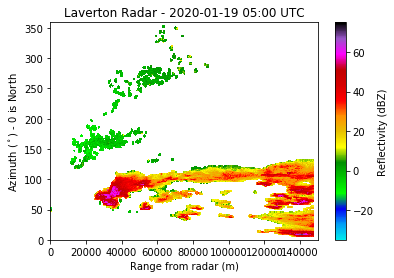

In [7]:
plt.pcolormesh(r, radar_azi, reflectivity, cmap='pyart_NWSRef', vmin=-35, vmax=75)
plt.xlabel('Range from radar (m)')
plt.ylabel(r'Azimuth $(^\circ)$ - 0 is North')
plt.colorbar(label='Reflectivity (dBZ)')
plt.title('Laverton Radar - 2020-01-19 05:00 UTC')
plt.xlim(0, 150e3)
plt.show()

In [8]:
# From angle bearing to mathematical angle.
azimuth = np.pi / 180 * ((450 - radar_azi) % 360)  
[R, A] = np.meshgrid(r, azimuth)

In [9]:
# From spherical to Cartesian
x = R * np.cos(A)
y = R * np.sin(A)

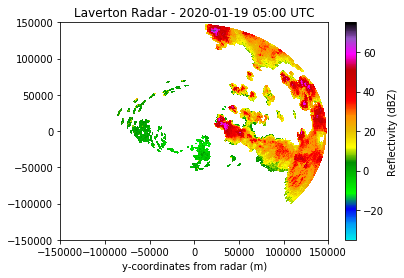

In [11]:
plt.pcolormesh(x, y, reflectivity, cmap='pyart_NWSRef', vmin=-35, vmax=75)
plt.xlabel('x-coordinates from radar (m)')
plt.xlabel('y-coordinates from radar (m)')
plt.colorbar(label='Reflectivity (dBZ)')
plt.title('Laverton Radar - 2020-01-19 05:00 UTC')
plt.xlim(-150e3, 150e3)
plt.ylim(-150e3, 150e3)
plt.show()

Let's plot the data onto a map

In [12]:
projection = ccrs.AzimuthalEquidistant(central_longitude=radar.longitude['data'][0],
                                       central_latitude=radar.latitude['data'][0])

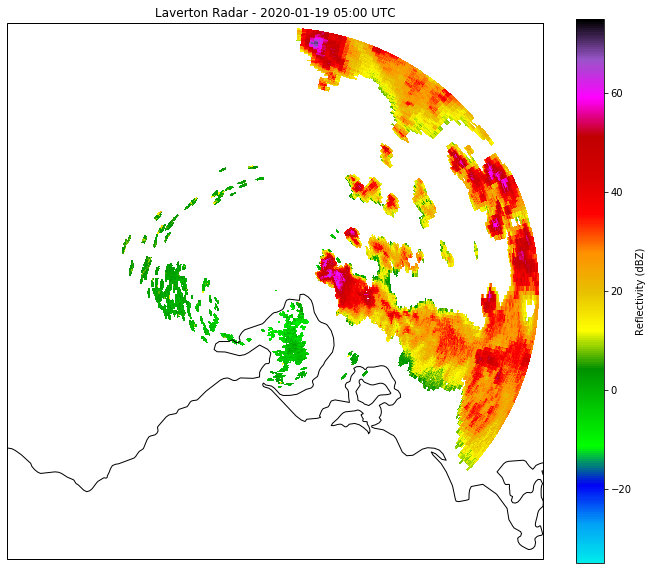

In [13]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(1, 1, 1, projection=projection)
ax1.coastlines('10m')
im = ax1.pcolormesh(x, y, reflectivity, cmap='pyart_NWSRef', vmin=-35, vmax=75)
ax1.set_xlim(-150e3, 150e3)
ax1.set_ylim(-150e3, 150e3)
plt.colorbar(im, label='Reflectivity (dBZ)')
plt.title('Laverton Radar - 2020-01-19 05:00 UTC')
plt.show()

In [14]:
grids = pyart.map.grid_from_radars(radar, grid_shape=(41, 121, 121), grid_limits=((0, 20e3), (-150e3, 150e3), (-150e3, 150e3)))

/home/548/vhl548/.local/miniconda3/envs/radar/lib/python3.7/site-packages/pyart/map/gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


In [15]:
grids.fields.keys()

dict_keys(['WRADH', 'TH', 'PHIDP', 'DBZH', 'ZDR', 'KDP', 'DBZH_CLEAN', 'SNRH', 'VRADH', 'VRADDH', 'RHOHV', 'ROI'])

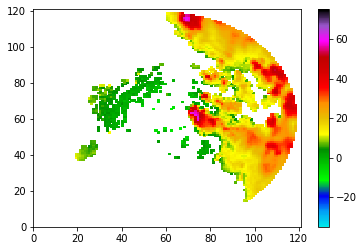

In [16]:
plt.pcolormesh(grids.fields['DBZH_CLEAN']['data'][5, :, :], cmap='pyart_NWSRef', vmin=-35, vmax=75)
plt.colorbar()